# Importing the necessary Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split


import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))



# Loading The Dataset

In [2]:
train = pd.read_csv("/home/bearbalalaika/Desktop/Kaggle/Digit/train.csv",dtype = np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



# Split data into features(pixels) and labels(numbers from 0 to 9)
## we normalize the values of feature so that it becomes easier for processing

In [3]:
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization


In [4]:
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,targets_numpy,test_size = 0.2,random_state = 2) 

## create feature and targets tensor for train and test set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable

In [5]:
X_train=torch.from_numpy(features_train).view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
y_train=torch.from_numpy(targets_train).type(torch.LongTensor)

X_test = torch.from_numpy(features_test).view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
y_test = torch.from_numpy(targets_test).type(torch.LongTensor)





# Getting the Train and Test sets for model to operate on

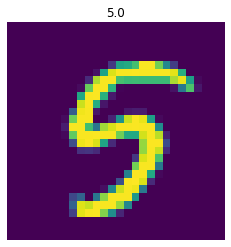

In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transforms = transforms.Compose([        
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(hue=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


batch_size=32
train=torch.utils.data.TensorDataset(X_train,y_train)
test=torch.utils.data.TensorDataset(X_test,y_test)


# data loader
train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=batch_size)
test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=batch_size)

# visualize one of the images in data set
plt.imshow(features_numpy[8].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[8]))
plt.savefig('graph.png')
plt.show()


In [7]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = test_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [8]:
# Resnet 
from torchvision import transforms, models
from torchvision.models import resnet50


model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

#model.fc = torch.nn.Linear(model.fc.in_features, 2)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 128), 
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(128, 10), 
#    torch.nn.LogSoftmax(dim=1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5.0e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)

## Lets Train our Model

In [11]:
from tqdm import tqdm
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


100%|██████████| 1050/1050 [00:36<00:00, 28.58it/s]

train Loss: 0.1969 Acc: 0.9492



100%|██████████| 263/263 [00:03<00:00, 80.60it/s]

val Loss: 0.0373 Acc: 0.9885
Epoch 1/9:



100%|██████████| 1050/1050 [00:37<00:00, 28.16it/s]

train Loss: 0.1077 Acc: 0.9759



100%|██████████| 263/263 [00:03<00:00, 81.34it/s] 

val Loss: 0.0539 Acc: 0.9843
Epoch 2/9:



100%|██████████| 1050/1050 [00:37<00:00, 27.81it/s]

train Loss: 0.0719 Acc: 0.9829



100%|██████████| 263/263 [00:03<00:00, 83.11it/s] 

val Loss: 0.0385 Acc: 0.9894
Epoch 3/9:



100%|██████████| 1050/1050 [00:37<00:00, 27.93it/s]

train Loss: 0.0704 Acc: 0.9840



100%|██████████| 263/263 [00:03<00:00, 79.55it/s]

val Loss: 0.0588 Acc: 0.9860
Epoch 4/9:



100%|██████████| 1050/1050 [00:38<00:00, 27.49it/s]

train Loss: 0.0411 Acc: 0.9909



100%|██████████| 263/263 [00:03<00:00, 79.76it/s] 

val Loss: 0.0251 Acc: 0.9931
Epoch 5/9:



100%|██████████| 1050/1050 [00:37<00:00, 27.89it/s]

train Loss: 0.0264 Acc: 0.9939



100%|██████████| 263/263 [00:03<00:00, 79.23it/s] 

val Loss: 0.0256 Acc: 0.9937
Epoch 6/9:



100%|██████████| 1050/1050 [00:38<00:00, 27.57it/s]

train Loss: 0.0178 Acc: 0.9958



100%|██████████| 263/263 [00:03<00:00, 76.22it/s]

val Loss: 0.0232 Acc: 0.9942
Epoch 7/9:



100%|██████████| 1050/1050 [00:38<00:00, 27.58it/s]

train Loss: 0.0129 Acc: 0.9968



100%|██████████| 263/263 [00:03<00:00, 76.22it/s]

val Loss: 0.0260 Acc: 0.9942
Epoch 8/9:



100%|██████████| 1050/1050 [00:38<00:00, 27.48it/s]

train Loss: 0.0119 Acc: 0.9973



100%|██████████| 263/263 [00:03<00:00, 75.81it/s]

val Loss: 0.0238 Acc: 0.9949
Epoch 9/9:



100%|██████████| 1050/1050 [00:38<00:00, 27.29it/s]

train Loss: 0.0071 Acc: 0.9981



100%|██████████| 263/263 [00:03<00:00, 78.66it/s] 

val Loss: 0.0242 Acc: 0.9943


In [10]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=3.0e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)

In [13]:
final_test = pd.read_csv("/home/bearbalalaika/Desktop/Kaggle/Digit/test.csv",dtype = np.float32)
final_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:

features_final_test_numpy = final_test.values/255 # normalization

In [16]:
features_final=torch.from_numpy(features_final_test_numpy).view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

In [17]:
y_final=np.zeros(features_final_test_numpy.shape)

y_final = torch.from_numpy(y_final)

final=torch.utils.data.TensorDataset(features_final,y_final)


final_loader = torch.utils.data.DataLoader(
    final, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [19]:

# Making it submission ready
submission = [['ImageId', 'Label']]

# Turn off gradients for validation
with torch.no_grad():
    model.eval()
    image_id = 1
    for images, _ in final_loader:
        images = images.to(device)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1

In [20]:
submission_df = pd.DataFrame(submission)
submission_df.columns = submission_df.iloc[0]
submission_df = submission_df.drop(0, axis=0)

In [21]:
submission_df.to_csv("submission.csv", index=False)